In [1]:
import numpy as np
np.random.seed(69696969)
import requests
import json

In [2]:
wins = {}
losses = {}
both = {}

def remove_non_ascii(text):
    return ''.join(i for i in text if ord(i)<128)

for i in range(1,3):
    filename = 'games100-' + str(i) + '.json'
    with open(filename, 'r', encoding="utf-8") as data_file:
        data = json.load(data_file)

        for element in data:
            element['match_id'] = str(element['match_id']).replace('[', '').replace(']', '')
            element['radiant_win'] = str(element['radiant_win']).replace('[', '').replace(']', '')
            r = element

            r.pop('all_word_counts', None)
    #         r.pop('match_id', None)
            r.pop('barracks_status_dire', None)
            r.pop('barracks_status_radiant', None)
    #         r.pop('chat', None)
            r.pop('cluster', None)
            r.pop('cosmetics', None)
            r.pop('dire_score', None)
            r.pop('dire_team_id', None)
            r.pop('draft_timings', None)
            r.pop('duration', None)
            r.pop('engine', None)
    #         r.pop('first_blood_time', None)
    #         r.pop('game_mode', None)
            r.pop('human_players', None)
            r.pop('leagueid', None)
            r.pop('lobby_type', None)
            r.pop('match_seq_num', None)
            r.pop('negative_votes', None)
            r.pop('objectives', None)
            r.pop('picks_bans', None)
            r.pop('positive_votes', None)
            r.pop('radiant_gold_adv', None)
            r.pop('radiant_score', None)
            r.pop('radiant_team_id', None)
    #         r.pop('radiant_win', None)
            r.pop('radiant_xp_adv', None)
            r.pop('skill', None)
            r.pop('start_time', None)
            r.pop('teamfights', None)
            r.pop('tower_status_dire', None)
            r.pop('tower_status_radiant', None)
            r.pop('version', None)
            r.pop('replay_salt', None)
            r.pop('series_id', None)
            r.pop('series_type', None)
            r.pop('players', None)
            r.pop('patch', None)
            r.pop('region', None)
            r.pop('throw', None)
            r.pop('loss', None)
            r.pop('win', None)
            r.pop('my_word_counts', None)
            r.pop('comeback', None)
            r.pop('stomp', None)
            r.pop('replay_url', None)

            pop_chat = []
            for index, item in enumerate(r['chat']):
                if item['slot'] == 10:
                    pop_chat.append(index)

            with open('chat_wheel.json', 'r',encoding='utf8') as data_file:
                chat_wheel = json.load(data_file)

            for idx, item in enumerate(r['chat']):
                if item['type'] == 'chatwheel':
                    item['type'] = 'chat'
                    item['key'] = chat_wheel[item['key']].get('message')

            for index, item in enumerate(r['chat']):
                if item['type'] == 'chat':
                    if item['key'] is not None:
                        remove_non_ascii(item['key'])

            
            both[element['match_id']] = r

            if r['radiant_win'] == str('True'):
                wins[element['match_id']] = r
            else:
                losses[element['match_id']] = r
                
    data_file.close()

In [3]:
# wins

In [4]:
import copy
win_chats={}
lose_chats={}
for game in wins:
    game_copy = copy.deepcopy(wins[game])
    game_copy['chat']=[line for line in wins[game]['chat'] if not (line['slot']>4)]
    #print(game_copy)
    win_chats[game]=game_copy
    
    game_copy = copy.deepcopy(wins[game])
    game_copy['chat']=[line for line in wins[game]['chat'] if not (line['slot']<=4)]
    #print(game_copy)
    lose_chats[game]=game_copy

for game in losses:
    game_copy = copy.deepcopy(losses[game])
    game_copy['chat']=[line for line in losses[game]['chat'] if not (line['slot']>4)]
    lose_chats[game]=game_copy
    
    game_copy = copy.deepcopy(losses[game])
    game_copy['chat']=[line for line in losses[game]['chat'] if not (line['slot']<=4)]
    #print(game_copy)
    win_chats[game]=game_copy

# print(win_chats) 
# print(len(win_chats))
# print(lose_chats) 
# len(lose_chats)


In [5]:
wordDict = {}
for game in both.keys():
    for i in both[game]['chat']:
        if i['key'] is not None:
            for word in i['key'].split():
                if word in wordDict:
                    wordDict[word] = wordDict[word]+1
                else:
                    wordDict[word]=1
        

In [6]:
# print(len(both.keys()))
# for i in both.keys():
#     print(i)

In [7]:
# wordDict

In [8]:
import operator
wordDictCounts = sorted(wordDict.items(), key=operator.itemgetter(1))

In [9]:
# wordDictCounts[::-1]

In [10]:
words = list(wordDict.keys())

In [11]:
# words

In [12]:
words.insert(0,'Win')

In [13]:
import numpy as np
AllWords = np.zeros((len(both)*2,len(wordDict)+1), dtype=int)
game_index = 0
for game in win_chats.keys():
    AllWords[game_index][0]=1
    for line in win_chats[game]['chat']:
        if line['key'] is not None:
            for word in line['key'].split():
                AllWords[game_index][words.index(word)]=AllWords[game_index][words.index(word)]+1
    game_index+=1
for game in lose_chats.keys():
    for line in lose_chats[game]['chat']:
        if line['key'] is not None:
            for word in line['key'].split():
                AllWords[game_index][words.index(word)]=AllWords[game_index][words.index(word)]+1
    game_index+=1

In [14]:
# AllWords

In [15]:
import pandas as pd 
df = pd.DataFrame(AllWords, columns = words) 

In [16]:
df
# df.to_csv('allgames.csv')

,Win,Thanks!,Missing,bottom!,Well,played!,%s1,is,missing!,nice,...,Wrong.,tip??,ez?,заебало,терпеть,здохла,ХД,jagg,faster,slots
0,1,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,2,2,0,0,10,10,10,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,3,5,3,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,2,0,3,3,4,4,4,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,0,0,0,0,2,2,5,5,5,0,...,0,0,0,0,0,0,0,0,0,0
412,0,4,0,0,3,3,7,7,7,0,...,0,0,0,0,0,0,0,0,0,0
413,0,0,4,0,2,2,4,4,4,0,...,0,0,0,0,0,0,0,0,0,0
414,0,0,2,1,0,0,3,3,3,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
X = df.iloc[:,1:].values
y = df.iloc[:,0].values

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [19]:
# y_test

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=False)
# StandardScaler(copy=False,with_mean=False).fit(X_train)
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=6)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

In [22]:
y_pred = classifier.predict(X_test)

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[42  2]
 [36  4]]
              precision    recall  f1-score   support

           0       0.54      0.95      0.69        44
           1       0.67      0.10      0.17        40

    accuracy                           0.55        84
   macro avg       0.60      0.53      0.43        84
weighted avg       0.60      0.55      0.44        84



In [24]:
# error = []

# # Calculating error for K values between 1 and 40
# for i in range(1, 40):
# #     print(i)
#     knn = KNeighborsClassifier(n_neighbors=i)
#     knn.fit(X_train, y_train)
#     pred_i = knn.predict(X_test)
#     error.append(np.mean(pred_i != y_test))

In [25]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 6))
# plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
#          markerfacecolor='blue', markersize=10)
# plt.title('Error Rate K Value')
# plt.xlabel('K Value')
# plt.ylabel('Mean Error')

In [26]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB(priors = [.5,.5])

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(X_test)

In [27]:
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5714285714285714


In [28]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn import tree
import graphviz

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

# tree.plot_tree(clf, max_depth = 2)
dot_data = tree.export_graphviz(clf, out_file=None, filled=True, rounded=True, special_characters=True, max_depth = 2, feature_names=words[1:], class_names=["loss", "win"])  
graph = graphviz.Source(dot_data)  

#Predict the response for test dataset
y_pred = clf.predict(X_test)

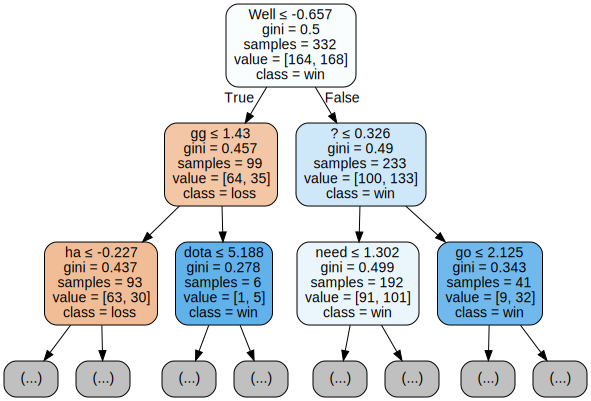

In [29]:
graph

In [30]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5714285714285714


In [31]:
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=3, shuffle=True, random_state=0)
clf = DecisionTreeClassifier()
print(cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1))

[0.47747748 0.59459459 0.56363636]


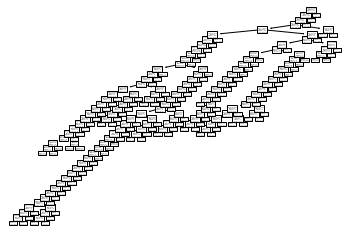

In [32]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

estimator = clf.estimators_[9]

tree.plot_tree(estimator)
dot_data = tree.export_graphviz(estimator, out_file=None, filled=True, rounded=True, special_characters=True, max_depth = 2, feature_names=words[1:], class_names=["loss", "win"])  
graph = graphviz.Source(dot_data)  

y_pred=clf.predict(X_test)

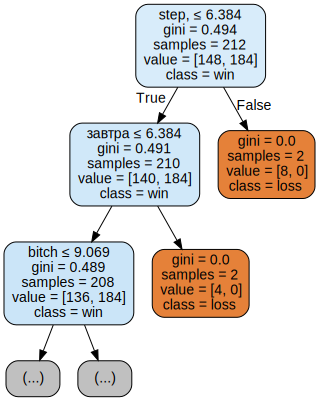

In [33]:
graph

In [34]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5952380952380952


In [35]:
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=3, shuffle=True, random_state=0)
clf = RandomForestClassifier(n_estimators=91)
print(cross_val_score(clf, X, y, cv=k_fold, n_jobs=1))

[0.58992806 0.51079137 0.53623188]


In [36]:
from sklearn.model_selection import KFold, cross_val_score
Forest_numbers={}
for k in range(51,151,10):
    k_fold = KFold(n_splits=11, shuffle=True, random_state=0)
    clf = RandomForestClassifier(n_estimators=k)
    Forest_numbers[k] = cross_val_score(clf, X, y, cv=k_fold, n_jobs=1)

In [37]:
Forest_numbers

{51: array([0.63157895, 0.57894737, 0.76315789, 0.5       , 0.52631579,
        0.44736842, 0.52631579, 0.44736842, 0.52631579, 0.45945946,
        0.7027027 ]),
 61: array([0.63157895, 0.57894737, 0.71052632, 0.52631579, 0.55263158,
        0.52631579, 0.60526316, 0.44736842, 0.55263158, 0.45945946,
        0.56756757]),
 71: array([0.71052632, 0.52631579, 0.68421053, 0.44736842, 0.57894737,
        0.47368421, 0.60526316, 0.52631579, 0.55263158, 0.48648649,
        0.72972973]),
 81: array([0.71052632, 0.52631579, 0.65789474, 0.52631579, 0.55263158,
        0.55263158, 0.5       , 0.5       , 0.5       , 0.54054054,
        0.56756757]),
 91: array([0.65789474, 0.63157895, 0.68421053, 0.57894737, 0.57894737,
        0.55263158, 0.52631579, 0.55263158, 0.55263158, 0.48648649,
        0.56756757]),
 101: array([0.63157895, 0.55263158, 0.73684211, 0.52631579, 0.5       ,
        0.52631579, 0.57894737, 0.52631579, 0.47368421, 0.45945946,
        0.67567568]),
 111: array([0.65789474, 0.

In [38]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
# df

In [39]:
scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(X_train[:, 1:])

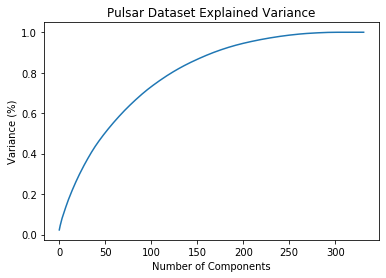

In [40]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(data_rescaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [43]:
# pca.explained_variance_ratio_

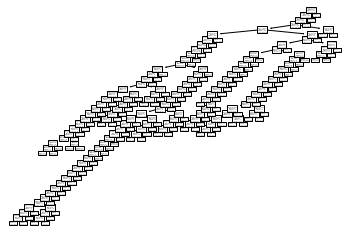

In [32]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

estimator = clf.estimators_[9]

tree.plot_tree(estimator)
dot_data = tree.export_graphviz(estimator, out_file=None, filled=True, rounded=True, special_characters=True, max_depth = 2, feature_names=words[1:], class_names=["loss", "win"])  
graph = graphviz.Source(dot_data)  

y_pred=clf.predict(X_test)

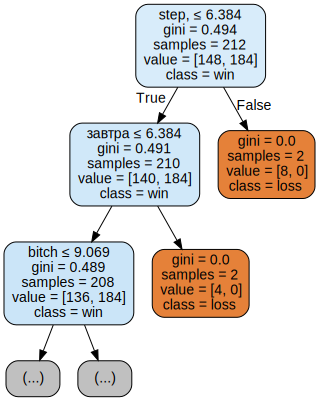

In [33]:
graph

In [34]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5952380952380952
